**Projeto Integrado - IA + IOT na manutenção preditiva**

Instalação e importação de bibliotecas necessárias

In [ ]:
!pip install imblearn --upgrade
!pip install plotly --upgrade
!pip install chart-studio --upgrade

     |████████████████████████████████| 23.9 MB 14 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 64 kB 1.8 MB/s 


In [ ]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly as plotly
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import types
import pandas as pd
def __iter__(self): return 0

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Importação dos dados via GitHub

In [ ]:
!rm equipment_failure_data_1.csv
#importando 
!wget https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv
# Converte o csv para um pandas df
pd_data_1 = pd.read_csv("equipment_failure_data_1.csv", sep=",", header=0)

!rm equipment_failure_data_2.csv

!wget https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv

# Converte o csv para um pandas df
pd_data_2 = pd.read_csv("equipment_failure_data_2.csv", sep=",", header=0)

#Concatenação dos diferentes arquivos em um df
pd_data=pd.concat([pd_data_1, pd_data_2])

rm: cannot remove 'equipment_failure_data_1.csv': No such file or directory
--2021-09-27 02:51:31--  https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11219474 (11M) [text/plain]
Saving to: ‘equipment_failure_data_1.csv’

equipment_failure_d 100%[===================>]  10.70M  63.1MB/s    in 0.2s    

2021-09-27 02:51:32 (63.1 MB/s) - ‘equipment_failure_data_1.csv’ saved [11219474/11219474]

rm: cannot remove 'equipment_failure_data_2.csv': No such file or directory
--2021-09-27 02:51:32--  https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109

**Análise Exploratória**

In [ ]:
pd_data.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,100001,12/2/14,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880
1,100001,12/3/14,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881
2,100001,12/4/14,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882
3,100001,12/5/14,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883
4,100001,12/6/14,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884


In [ ]:
pd_data.shape

(307751, 16)

In [ ]:
# contagem das diferentes datas no df
xxxx = pd.DataFrame(pd_data.groupby(['DATE']).agg(['count']))
xxxx.shape

(731, 15)

In [ ]:
#contagem das diferentes máquinas
xxxx = pd.DataFrame(pd_data.groupby(['ID']).agg(['count']))
xxxx.shape

(421, 15)

Temos 421 máquinas em 731 datas diferentes

In [ ]:
# Temos 421 máquinas em 731 datas diferentes

In [ ]:
#contagem do número total de registros
df_failure_thingy=pd_data
df_failure_thingy=df_failure_thingy.drop_duplicates(subset=['ID','DATE'])
df_failure_thingy.shape

(307751, 16)

O dataset conta com 307751 registros

In [ ]:
# busca de valores nulos
pd_data.isnull().sum(axis = 0)

ID                    0
DATE                  0
REGION_CLUSTER        0
MAINTENANCE_VENDOR    0
MANUFACTURER          0
WELL_GROUP            0
S15                   0
S17                   0
S13                   0
S5                    0
S16                   0
S19                   0
S18                   0
EQUIPMENT_FAILURE     0
S8                    0
AGE_OF_EQUIPMENT      0
dtype: int64

In [ ]:
# contando o número de falhas presentes 
xxxx = pd.DataFrame(pd_data.groupby(['EQUIPMENT_FAILURE'])['ID'].agg('count'))
xxxx

,ID
EQUIPMENT_FAILURE,
0,307330
1,421


1 significa que a máquina em questão falhou, portanto são observadas 421 falhas 

In [ ]:
# análise estatística geral das variáveis
pd_data.describe()

,ID,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
count,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000
mean,100310.826603,4.543943,14.585192,80.265541,35.018249,4675.848252,7.972097,9.069123,137.963064,0.001368,144.665715,2524.192399
std,177.574390,2.284121,8.817056,85.804273,14.446585,2521.074632,2.321949,16.898887,238.890128,0.036961,240.773926,3158.930976
min,100001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.490000,0.000000
25%,100161.000000,3.000000,7.694100,0.000000,28.200000,3209.000000,6.621500,0.900000,11.798276,0.000000,9.250000,721.000000
50%,100311.000000,5.000000,11.661600,31.680000,34.940000,4237.047619,8.004000,4.200000,38.200000,0.000000,53.080000,1113.000000
75%,100467.000000,6.000000,22.560000,160.080000,41.610000,5743.000000,9.460000,10.600000,150.900000,0.000000,165.092608,2784.000000
max,100617.000000,8.000000,59.040000,2555.520000,592.890000,52767.000000,24.600000,511.000000,4151.700000,1.000000,2068.110000,15170.000000


**Engenharia de Variáveis**

In [ ]:
# conversão da variável data para o formato datetime
pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])

In [ ]:
# criação de variável "flipper" - indicação da mudança de máquina
pd_data=pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])
pd_data['flipper'] = np.where((pd_data.ID != pd_data.ID.shift(1)), 1, 0)
pd_data.head()


,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,flipper
0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880,1
1,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881,0
2,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882,0
3,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883,0
4,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884,0


In [ ]:
feature_window = 21

In [ ]:
# criação de novas variáveis - time_since_start e too_soon - se too_soon = 1, temos menos de X(feature_window) dias de histórico da máquina em questão
dfx=pd_data
# pegando o primeiro registro de cada uma das máquinas, através da variável flipper
starter=dfx[dfx['flipper'] == 1]
starter=starter[['DATE','ID']]

#renomeando variável date
starter=starter.rename(index=str, columns={"DATE": "START_DATE"})

#conversão do start date para o tipo datetime
starter['START_DATE'] = pd.to_datetime(starter['START_DATE'])

#jogando start_date para o dataset inicial
dfx=dfx.sort_values(by=['ID', 'DATE'], ascending=[True, True])
starter=starter.sort_values(by=['ID'], ascending=[True])
dfx =dfx.merge(starter, on=['ID'], how='left')

#cálculo do número de dias após o começo 
dfx['C'] = dfx['DATE'] - dfx['START_DATE']
dfx['TIME_SINCE_START'] = dfx['C'] / np.timedelta64(1, 'D')
dfx=dfx.drop(columns=['C'])
dfx['too_soon'] = np.where((dfx.TIME_SINCE_START < feature_window) , 1, 0)



In [ ]:
#criação de média, máximo e mínimo para as variáveis referentes a sensores

dfx['S5_mean'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S5)
dfx['S5_median'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).median()) , dfx.S5)
dfx['S5_max'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).max()) , dfx.S5)
dfx['S5_min'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).min()) , dfx.S5)
dfx['S13_mean'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S13)
dfx['S13_median'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).median()) , dfx.S13)
dfx['S13_max'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).max()) , dfx.S13)
dfx['S13_min'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).min()) , dfx.S13)
dfx['S15_mean'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S15)
dfx['S15_median'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).median()) , dfx.S15)
dfx['S15_max'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).max()) , dfx.S15)
dfx['S15_min'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).min()) , dfx.S15)
dfx['S16_mean'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S16)
dfx['S16_median'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).median()) , dfx.S16)
dfx['S16_max'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).max()) , dfx.S16)
dfx['S16_min'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).min()) , dfx.S16)
dfx['S17_mean'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S17)
dfx['S17_median'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).median()) , dfx.S17)
dfx['S17_max'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).max()) , dfx.S17)
dfx['S17_min'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).min()) , dfx.S17)
dfx['S18_mean'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S18)
dfx['S18_median'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).median()) , dfx.S18)
dfx['S18_max'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).max()) , dfx.S18)
dfx['S18_min'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).min()) , dfx.S18)
dfx['S19_mean'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S19)
dfx['S19_median'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).median()) , dfx.S19)
dfx['S19_max'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).max()) , dfx.S19)
dfx['S19_min'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).min()) , dfx.S19)

In [ ]:
# criação de variável que indica picos bruscos nas medições dos sensores - mostra o quão distante o valor está da média

dfx['S5_chg'] = np.where((dfx.S5_mean == 0),0 , dfx.S5/dfx.S5_mean)
dfx['S13_chg'] = np.where((dfx.S13_mean == 0),0 , dfx.S13/dfx.S13_mean)
dfx['S15_chg'] = np.where((dfx.S15_mean==0),0 , dfx.S15/dfx.S15_mean)
dfx['S16_chg'] = np.where((dfx.S16_mean == 0),0 , dfx.S16/dfx.S16_mean)
dfx['S17_chg'] = np.where((dfx.S17_mean == 0),0 , dfx.S17/dfx.S17_mean)
dfx['S18_chg'] = np.where((dfx.S18_mean == 0),0 , dfx.S18/dfx.S18_mean)
dfx['S19_chg'] = np.where((dfx.S19_mean == 0),0 , dfx.S19/dfx.S19_mean)
#cópia para o dataset original
pd_data=dfx



**Lidando com a baixa quantidade relativa de falhas**

In [ ]:
#setando uma janela de 28 dias a serem considerados prévios a falha
target_window=28

#organizando valores por ID da máquina e data

pd_data=pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])
pd_data.reset_index(level=0, inplace=True)

# criação de um dataframe com os registros que possuem falha, renomeação de date para failure_date

df_failure_thingy=pd_data[pd_data['EQUIPMENT_FAILURE'] == 1]
df_failure_thingy=df_failure_thingy[['DATE','ID']]
df_failure_thingy=df_failure_thingy.rename(index=str, columns={"DATE": "FAILURE_DATE"})
pd_data=pd_data.sort_values(by=['ID'], ascending=[True])
df_failure_thingy=df_failure_thingy.sort_values(by=['ID'], ascending=[True])

In [ ]:
#  merge data no ID
pd_data =pd_data.merge(df_failure_thingy, on=['ID'], how='left')

In [ ]:
# cálculo do número de dias até a falha para cada registro
pd_data=pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])
pd_data['FAILURE_DATE'] = pd.to_datetime(pd_data['FAILURE_DATE'])
pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
pd_data['C'] = pd_data['FAILURE_DATE'] - pd_data['DATE']
pd_data['TIME_TO_FAILURE'] = pd_data['C'] / np.timedelta64(1, 'D')


In [ ]:
# ordenando por data e ID
pd_data=pd_data.drop(columns=['index'])
pd_data=pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])
pd_data.reset_index(inplace=True)


In [ ]:
# criação da variável failure_target - failure_target=1 quando quando a falha acontece dentro da janela failure_window

pd_data['FAILURE_TARGET'] = np.where(((pd_data.TIME_TO_FAILURE < target_window) & ((pd_data.TIME_TO_FAILURE>=0))), 1, 0)
tips_summed = pd_data.groupby(['FAILURE_TARGET'])['S5'].count()
tips_summed

FAILURE_TARGET
0    296011
1     11740
Name: S5, dtype: int64

In [ ]:
#média do failure target
pd_data['FAILURE_TARGET'].mean()

0.03814772332177637

O número de positivos na variável dependente aumentou, mas continua muito baixo e pode ser problemático para o treinamento do modelo

**Separação em conjuntos de treino, validação e teste**

In [ ]:
#criação de lista com IDs únicos
aa=pd_data
pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id.shape

(421, 1)

In [ ]:
#criaçaõ de variável aleatória
np.random.seed(42)
pd_id['wookie'] = (np.random.randint(0, 10000, pd_id.shape[0]))/10000
pd_id=pd_id[['ID', 'wookie']]

In [ ]:
#separação dos conjuntos
pd_id['MODELING_GROUP'] = np.where(((pd_id.wookie <= 0.35)), 'TRAINING', np.where(((pd_id.wookie <= 0.65)), 'VALIDATION', 'TESTING'))
tips_summed = pd_id.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       149
TRAINING      146
VALIDATION    126
Name: wookie, dtype: int64

In [ ]:
# relacionar cada registro individual com seu ID
pd_data=pd_data.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
pd_data =pd_data.merge(pd_id, on=['ID'], how='inner')

In [ ]:
#número de registros em cada um dos conjuntos
tips_summed = pd_data.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       108919
TRAINING      106726
VALIDATION     92106
Name: wookie, dtype: int64

In [ ]:
#criação de dataframe para o conjunto de treino

df_training=pd_data[pd_data['MODELING_GROUP'] == 'TRAINING']
df_training=df_training.drop(columns=['MODELING_GROUP','C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])

In [ ]:
#criação de dataframe para treino e teste
df_train_test=pd_data[pd_data['MODELING_GROUP'] != 'VALIDATION']
df_train_test=df_train_test.drop(columns=['wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_train_test.shape

(215645, 58)

In [ ]:
#criação de dataframe que inclua tudo
df_total=pd_data.drop(columns=['C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])

In [ ]:
# Mudança artificial do número de falhas para 50%
training_features=df_training[['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5',
 'S16','S19','S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median',
 'S15_max','S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min','S19_mean','S19_median','S19_max','S19_min',
 'S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']]
training_target=df_training[['FAILURE_TARGET']]

In [ ]:
#uso do smote para o equilíbrio artificial das ocorrências
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
smx = SMOTENC(random_state=12,  categorical_features=[0, 1, 2, 3])
x_res, y_res = smx.fit_sample(training_features, training_target.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#formatação das variáveis dependente e independente
df_x=pd.DataFrame(x_res)
df_x.columns = [
 'REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5','S16','S19',
 'S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median','S15_max',
 'S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min',
 'S19_mean','S19_median','S19_max','S19_min','S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']
df_y=pd.DataFrame(y_res)
df_y.columns = ['FAILURE_TARGET']

In [ ]:
#conferir se agora o número de falhas está balanceado
df_y.mean(axis = 0)

FAILURE_TARGET    0.5
dtype: float64

In [ ]:
#jogar esses novos dados para um novo df
df_balanced = pd.concat([df_y, df_x], axis=1)

Transformação dos dados e Engenharia de Variáveis. 

Vamos converter as variáveis categóricas em variáveis numéricas, pois o modelo que será usado (XGBT) não lida bem com varíaveis categóricas. 

In [ ]:
df_dv = pd.get_dummies(df_balanced['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})
df_balanced= pd.concat([df_balanced, df_dv], axis=1)

df_dv = pd.get_dummies(df_balanced['MAINTENANCE_VENDOR'])
df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})
df_balanced = pd.concat([df_balanced, df_dv], axis=1)

df_dv = pd.get_dummies(df_balanced['MANUFACTURER'])
df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})
df_balanced = pd.concat([df_balanced, df_dv], axis=1)

df_dv = pd.get_dummies(df_balanced['WELL_GROUP'])
df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})
df_balanced = pd.concat([df_balanced, df_dv], axis=1)

Vamos aplicar a mesma transformação no conjunto de dados de treinamento.

In [ ]:
df_dv = pd.get_dummies(df_train_test['REGION_CLUSTER'])
df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})

df_train_test= pd.concat([df_train_test, df_dv], axis=1)
df_dv = pd.get_dummies(df_train_test['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})
df_train_test = pd.concat([df_train_test, df_dv], axis=1)

df_dv = pd.get_dummies(df_train_test['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})

df_train_test = pd.concat([df_train_test, df_dv], axis=1)

df_dv = pd.get_dummies(df_train_test['WELL_GROUP'])
df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})

df_train_test = pd.concat([df_train_test, df_dv], axis=1)

Aplicaremos também no df_total data set. 

In [ ]:
df_dv = pd.get_dummies(df_total['REGION_CLUSTER'])
df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})

df_total= pd.concat([df_total, df_dv], axis=1)

df_dv = pd.get_dummies(df_total['MAINTENANCE_VENDOR'])
df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})

df_total = pd.concat([df_total, df_dv], axis=1)

df_dv = pd.get_dummies(df_total['MANUFACTURER'])
df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})

df_total = pd.concat([df_total, df_dv], axis=1)

df_dv = pd.get_dummies(df_total['WELL_GROUP'])
df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})

df_total = pd.concat([df_total, df_dv], axis=1)

# Construindo o modelo no dataset balanceado. 


In [ ]:
df_balanced=df_balanced.drop(columns=['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP'])

features = [x for x in df_balanced.columns if x not in ['FAILURE_TARGET','EQUIPMENT_FAILURE']]  
dependent=pd.DataFrame(df_balanced['FAILURE_TARGET'])
independent=df_balanced.drop(columns=['FAILURE_TARGET'])

#Garantir que todas as variáveis são numéricas
independent = independent.apply(pd.to_numeric) 
df_balanced = df_balanced.apply(pd.to_numeric)

In [ ]:
# Definindo as especs do modelo

import matplotlib.pylab as plt
%matplotlib inline
def evaluate_model(alg, train, target, predictors,  early_stopping_rounds=1):
    
   
    #Fit the algorithm on the data
    alg.fit(train[predictors], target['FAILURE_TARGET'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train[predictors])
    dtrain_predprob = alg.predict_proba(train[predictors])[:,1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g') 
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target['FAILURE_TARGET'].values, dtrain_predictions))
    print("AUC Score (Balanced): %f" % metrics.roc_auc_score(target['FAILURE_TARGET'], dtrain_predprob))

In [ ]:
# Vamos utilizar os parâmetros padrões do modelo

xgb0 = XGBClassifier(
 objective= 'binary:logistic')


Model Report
Accuracy : 0.8272
AUC Score (Balanced): 0.912646


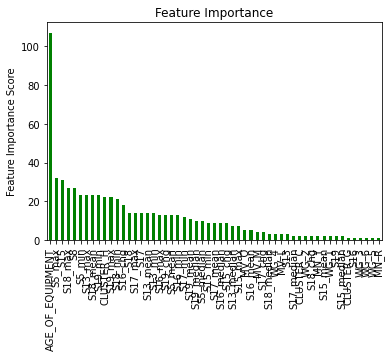

In [ ]:
evaluate_model(xgb0, independent, dependent,features)

Com um corte em 50%, a acurácia é de 0.835. E AUC fica de 0.916 utilizando o dataset balanceado. 
Agora vamos utilizar um dataframe desbalanceado, tentando aproximar mais da realidade. 

In [ ]:
df_testing=df_train_test[df_train_test['MODELING_GROUP'] == 'TESTING'].copy()
df_training=df_train_test[df_train_test['MODELING_GROUP'] != 'TESTING'].copy()

df_training['P_FAIL'] = xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_FAIL'] = np.where(((df_training.P_FAIL <= .50)), 0, 1)


print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FAILURE_TARGET'].values, df_training['Y_FAIL']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['FAILURE_TARGET'], df_training['P_FAIL']))

Accuracy : 0.7737
AUC Score (Train): 0.885915


Agora, com um corte em 50%, conseguimos uma acurácia de 0.79 e AUC de 0.890. 

Vamos aplicar o modelo no dataset de teste. 

In [ ]:
wdf_testing['P_FAIL']= xgb0.predict_proba(df_testing[features])[:,1];
df_testing['Y_FAIL'] = np.where(((df_testing.P_FAIL <= .67)), 0, 1)

print("Accuracy : %.4g" % metrics.accuracy_score(df_testing['FAILURE_TARGET'].values, df_testing['Y_FAIL']))
print("AUC Score (Test): %f" % metrics.roc_auc_score(df_testing['FAILURE_TARGET'], df_testing['P_FAIL']))

Accuracy : 0.9421
AUC Score (Test): 0.591206
